In [1]:
#IMPORTS
import string
from collections import Counter
import datetime as dt
from numpy import array
import numpy as np
import pickle
from pickle import load, dump
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications import ResNet152V2
from keras.applications import InceptionResNetV2
from keras.models import Model
from keras.preprocessing import image
# from keras.applications.inception_v3 import preprocess_input
# from keras.applications.resnet_v2 import preprocess_input
from keras.applications.inception_resnet_v2 import preprocess_input
from keras import Input
from keras.layers import Dropout, Dense, Embedding, LSTM
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#RUN THIS CELL ONLY ONCE
import wandb
wandb.init(project="model6")

wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/vipul43/model6/runs/1yz5iyjy

In [3]:
#EXTRACTING TEXT DATA AND PREPROCESSING
#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr8k.token.txt"
file = open(filepath, 'r')
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A DICTIONARY FOR TIME EFFICIENCY PURPOSES
tokens_dic = {}
for line in lines:
    tokens = line.split()
    image_ = tokens[0]
    caption = ' '.join(tokens[1:])
    image_title = image_.split('.')[0]
    if(image_title not in tokens_dic.keys()):
        tokens_dic[image_title] = [caption]
    else:
        tokens_dic[image_title].append(caption)


#STEP: PREPROCESSING
table = str.maketrans('', '', string.punctuation)
for captions in tokens_dic.values():
    for i in range(len(captions)):
        caption = captions[i]
        words = caption.split()
        words = [word.lower() for word in words]
        words = [word.translate(table) for word in words]
        words = [word for word in words if len(word)>1]
        words = [word for word in words if word.isalpha()]
        captions[i] = ' '.join(words)
        

#LOADING TRAINING SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
train = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    train.append(image_title)
#NOTE: SIZE OF TRAIN LIST IS 6000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
train_dataset = {}
max_caption_length = 0
for image_title, captions in tokens_dic.items():
    if(image_title in train and (image_title not in train_dataset.keys())):
        train_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            train_dataset[image_title].append(refined_caption)
            max_caption_length = max(max_caption_length, len(refined_caption.split()))
#NOTE: SIZE OF TRAIN DATASET IS 6000


#LOADING CROSS VALIDATION(OR DEVELOPMENT) SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
dev = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    dev.append(image_title)
#NOTE: SIZE OF TEST LIST IS 1000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
dev_dataset = {}
for image_title, captions in tokens_dic.items():
    if(image_title in dev and (image_title not in dev_dataset.keys())):
        dev_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            dev_dataset[image_title].append(refined_caption)
#NOTE: SIZE OF DEV DATASET IS 1000


#LOADING TESTING SET

#STEP: EXTRACTING DATA
filepath = "../../../Downloads/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt"
file = open(filepath, "r")
content = file.read()
file.close()
lines = content.split('\n')

#STEP: SAVING DATA IN A LIST
test = []
for line in lines:
    [image_title, stuff] =  line.split('.')
    test.append(image_title)
#NOTE: SIZE OF TEST LIST IS 1000

#STEP: SAVING IMAGE-CAPTIONS IN TRAIN DATASET
test_dataset = {}
for image_title, captions in tokens_dic.items():
    if(image_title in test and (image_title not in test_dataset.keys())):
        test_dataset[image_title] = list()
        for caption in captions:
            refined_caption = "startseq " + caption + " endseq"
            test_dataset[image_title].append(refined_caption)
#NOTE: SIZE OF TEST DATASET IS 1000


#CONSTRUCTING VOCABULARY FROM CAPTIONS
vocabulary = set()
for captions in tokens_dic.values():
    for caption in captions:
        for word in caption.split():
            vocabulary.add(word)
#NOTE: SIZE OF VOCABULARY BY NOT LETTING 1 LENGTH WORDS BE IN CAPTION IS 8763

#CONSTRUCTING MOST PROBABLE VOCABULARY FROM ALL TRAIN WORDS
word_count_threshold = 10
all_train_words = []
for captions in train_dataset.values():
    for caption in captions:
        words = caption.split()
        for word in words:
            all_train_words.append(word)

counter = Counter(all_train_words)
commons = counter.most_common()
most_probable_vocabulary = set()
for ele in commons:
    if(ele[1]>=word_count_threshold):
        most_probable_vocabulary.add(ele[0])
vocabulary_size = len(most_probable_vocabulary)
#NOTE: SIZE OF MOST PROBABLE VOCABULARY BY NOT LETTING 1 LENGTH WORDS BE IN CAPTION IS 1651


#READING ENCODED TRAIN IMAGES, ENCODED DEV IMAGES AND ENCODED TEST IMAGES FROM PKL FILES
encoded_train_images = {}
encoded_dev_images = {}
encoded_test_images = {}
with open("encoded_train_images3.pkl", "rb") as encoded_pickle:
    encoded_train_images = load(encoded_pickle)
    
with open("encoded_test_images3.pkl", "rb") as encoded_pickle:
    encoded_test_images = load(encoded_pickle)
    
with open("encoded_dev_images3.pkl", "rb") as encoded_pickle:
    encoded_dev_images = load(encoded_pickle)


def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocabulary_size+1)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0
                
                
#USEFUL DICTIONARIES
index_to_word = {}
word_to_index = {}
index = 1
for word in most_probable_vocabulary:
    index_to_word[index] = word
    word_to_index[word] = index
    index+=1


#WORD EMBEDDINGS, MAPPING EVERY WORD OF OUR MOST PROBABALE VOCABULARY TO 200 DIMENSION VECTOR, FOR THAT WE WILL BE USING GLOVE
embeddings = {}
file = open("../../../Downloads/glove/glove.6B.200d.txt", "r")
content = file.read()
file.close()
lines = content.split('\n')
for line in lines:
    word_and_vector = line.split()
    word = word_and_vector[0]
    vector = word_and_vector[1:]
    vector = np.asarray(vector, dtype='float32')
    embeddings[word] = vector
    
    
#MAPPING MOST PROBABLE VOCABULARY TO VECTOR BY CREATING A DENSE MATRIX WITH ROW AS WORD AND COLUMNS ARE 200 DIMENSIONS OF VECTOR
embedding_dim = 200
embeddings_matrix = np.zeros((vocabulary_size+1, embedding_dim))
for word, index in word_to_index.items():
    vector = embeddings.get(word)
    if(vector is not None):
        embeddings_matrix[index]=vector
#NOTE: DIMENSION OF EMBEDDINGS MATRIX IS (MOST PROBABLE VOCABULARY X 200), HERE (1951 X 200)
#NOTE: 1ST ROW OF EMBEDDINGS MATRIX IS ALL ZEROS

## model
<img src="files/images/model1_arch.png">
<img src="files/images/model_summary.png">
<img src="files/images/model_performance.png">

## model2
<img src="files/images/model2_arch.png">
<img src="files/images/model2_summary.png">
<img src="files/images/model2_performance.png">

## model3
<img src="files/images/model3_arch.png">
<img src="files/images/model3_summary.png">
<img src="files/images/model3_performance.png">

## model4
<img src="files/images/model4_arch.png">
<img src="files/images/model4_summary.png">
<img src="files/images/model4_performance.png">

## model5
<img src="files/images/model5_arch.png">
<img src="files/images/model5_summary.png">
<img src="files/images/model5_performance.png">

In [4]:
#SAME ARCHITECTURE AS MODEL
input1 = Input(shape=(1536,))
fe1 = Dropout(0.5)(input1)
fe2 = Dense(256, activation='relu')(fe1)

input2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocabulary_size+1, embedding_dim, mask_zero=True)(input2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)

output = Dense(vocabulary_size+1, activation='softmax')(decoder2)
model6 = Model(inputs=[input1, input2], outputs=output, name="model6")

model6.summary()

Model: "model6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1536)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1536)         0           input_1[0][0]                    
_____________________________________________________________________________________________

In [5]:
#SETTING ADDITIONAL PROPERTIES FOR EMBEDDING LAYER
model6.layers[2].set_weights([embeddings_matrix])
model6.layers[2].trainable = False

model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
wandb.config.dropout = 0.5
wandb.config.hidden_layer_size = 3
wandb.config.epochs=30

wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
#HYPERPARAMETERS OF TRAINING SESSION 1
#NOTE: DEFAULT LEARNING RATE OF KERAS MODEL IS 0.001
epochs = 20
batch_size = 3
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [8]:
#TRAINING SESSION 1
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = model6.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss = hist.history['loss']
    wandb.log({'epoch': i+1, 'loss': loss})
model6.save('./model6_weights/model_' + str(0) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 790s 395ms/step - loss: 4.1228 - accuracy: 0.2407


wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/1
2000/2000 [==============================] - 697s 349ms/step - loss: 3.4063 - accuracy: 0.2952
Epoch 1/1
2000/2000 [==============================] - 694s 347ms/step - loss: 3.1812 - accuracy: 0.3146
Epoch 1/1
2000/2000 [==============================] - 698s 349ms/step - loss: 3.0442 - accuracy: 0.3264
Epoch 1/1
2000/2000 [==============================] - 707s 354ms/step - loss: 2.9490 - accuracy: 0.3356
Epoch 1/1
2000/2000 [==============================] - 706s 353ms/step - loss: 2.8722 - accuracy: 0.3423
Epoch 1/1
2000/2000 [==============================] - 709s 354ms/step - loss: 2.8133 - accuracy: 0.3484
Epoch 1/1
2000/2000 [==============================] - 712s 356ms/step - loss: 2.7636 - accuracy: 0.3532
Epoch 1/1
2000/2000 [==============================] - 716s 358ms/step - loss: 2.7233 - accuracy: 0.3580
Epoch 1/1
1610/2000 [=======================>......] - ETA: 2:24 - loss: 2.6847 - accuracy: 0.3631

requests_with_retry encountered retryable exception: ('Connection aborted.', OSError("(60, 'ETIMEDOUT')")). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wandb-events.jsonl': {'offset': 200, 'content': ['{"system.cpu": 90.65, "system.memory": 71.39, "system.disk": 38.2, "system.proc.memory.availableMB": 2344.4, "system.proc.memory.rssMB": 1014.67, "system.proc.memory.percent": 12.39, "system.proc.cpu.threads": 41.0, "syste

1617/2000 [=======================>......] - ETA: 2:21 - loss: 2.6844 - accuracy: 0.3631

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c526de4d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1632/2000 [=======================>......] - ETA: 2:15 - loss: 2.6863 - accuracy: 0.3629

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d41f8ec10>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1658/2000 [=======================>......] - ETA: 2:06 - loss: 2.6868 - accuracy: 0.3627

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c52a7f550>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1711/2000 [========================>.....] - ETA: 1:46 - loss: 2.6895 - accuracy: 0.3622

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c52a844d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1805/2000 [==========================>...] - ETA: 1:11 - loss: 2.6882 - accuracy: 0.3623

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d41f73890>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1997/2000 [============================>.] - ETA: 1s - loss: 2.6866 - accuracy: 0.3622

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d41f8ec10>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

2000/2000 [==============================] - 729s 365ms/step - loss: 2.6864 - accuracy: 0.3622
Epoch 1/1
 443/2000 [=====>........................] - ETA: 8:53 - loss: 2.6478 - accuracy: 0.3640

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d41862150>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1262/2000 [=================>............] - ETA: 4:11 - loss: 2.6475 - accuracy: 0.3670

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d41f0e310>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

2000/2000 [==============================] - 682s 341ms/step - loss: 2.6541 - accuracy: 0.3655
Epoch 1/1
 309/2000 [===>..........................] - ETA: 9:37 - loss: 2.6420 - accuracy: 0.3636

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c526bbe10>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1193/2000 [================>.............] - ETA: 4:34 - loss: 2.6218 - accuracy: 0.3690

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c525ac510>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

2000/2000 [==============================] - 681s 341ms/step - loss: 2.6282 - accuracy: 0.3684
Epoch 1/1
 262/2000 [==>...........................] - ETA: 9:57 - loss: 2.6137 - accuracy: 0.3660

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d41f0e310>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1354/2000 [===================>..........] - ETA: 3:40 - loss: 2.5908 - accuracy: 0.3721

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c52675290>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

2000/2000 [==============================] - 683s 341ms/step - loss: 2.6012 - accuracy: 0.3708
Epoch 1/1
 378/2000 [====>.........................] - ETA: 9:17 - loss: 2.5812 - accuracy: 0.3702

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d41f75290>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1466/2000 [====================>.........] - ETA: 3:03 - loss: 2.5738 - accuracy: 0.3742

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d25a82c90>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

2000/2000 [==============================] - 687s 344ms/step - loss: 2.5803 - accuracy: 0.3732
Epoch 1/1
 410/2000 [=====>........................] - ETA: 9:10 - loss: 2.5610 - accuracy: 0.3723

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d41f0e310>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1385/2000 [===================>..........] - ETA: 3:31 - loss: 2.5516 - accuracy: 0.3774

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c525dc250>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

2000/2000 [==============================] - 689s 344ms/step - loss: 2.5609 - accuracy: 0.3757
Epoch 1/1
 283/2000 [===>..........................] - ETA: 10:21 - loss: 2.5573 - accuracy: 0.3713

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d41fea1d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1323/2000 [==================>...........] - ETA: 3:54 - loss: 2.5363 - accuracy: 0.3788

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d41fea1d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

2000/2000 [==============================] - 692s 346ms/step - loss: 2.5456 - accuracy: 0.3777
Epoch 1/1
 335/2000 [====>.........................] - ETA: 9:37 - loss: 2.5446 - accuracy: 0.3749

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c52a16450>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1362/2000 [===================>..........] - ETA: 3:39 - loss: 2.5148 - accuracy: 0.3825

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d36a9d890>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

2000/2000 [==============================] - 685s 342ms/step - loss: 2.5262 - accuracy: 0.3805
Epoch 1/1
 319/2000 [===>..........................] - ETA: 9:29 - loss: 2.5255 - accuracy: 0.3770

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c5259edd0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1375/2000 [===================>..........] - ETA: 3:30 - loss: 2.5012 - accuracy: 0.3836

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c526de090>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

2000/2000 [==============================] - 675s 337ms/step - loss: 2.5128 - accuracy: 0.3817
Epoch 1/1
 449/2000 [=====>........................] - ETA: 8:46 - loss: 2.4862 - accuracy: 0.3831

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c52a76a50>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1543/2000 [======================>.......] - ETA: 2:34 - loss: 2.4938 - accuracy: 0.3845

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c52693dd0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

2000/2000 [==============================] - 677s 339ms/step - loss: 2.4975 - accuracy: 0.3833
Epoch 1/1
 447/2000 [=====>........................] - ETA: 8:51 - loss: 2.4735 - accuracy: 0.3847

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9c52a7fb10>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

1549/2000 [======================>.......] - ETA: 2:33 - loss: 2.4809 - accuracy: 0.3856

requests_with_retry encountered retryable exception: HTTPSConnectionPool(host='api.wandb.ai', port=443): Max retries exceeded with url: /files/vipul43/model6/1yz5iyjy/file_stream (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f9d36a9d890>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')). args: ('https://api.wandb.ai/files/vipul43/model6/1yz5iyjy/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 23, 'content': ['2020-07-12T20:41:42.765019 1248/2000 [=================>............] - ETA: 4:35 - loss: 2.6798 - accuracy: 0.3633\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\x08\r']}, 'wa

2000/2000 [==============================] - 679s 340ms/step - loss: 2.4853 - accuracy: 0.3847


Retry attempt failed:
Traceback (most recent call last):
  File "/Users/vipul/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/Users/vipul/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/Users/vipul/anaconda3/lib/python3.7/socket.py", line 748, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/vipul/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/Users/vipul/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 376, in _make_request
    self

Exception in thread Thread-57:
Traceback (most recent call last):
  File "/Users/vipul/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/Users/vipul/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/Users/vipul/anaconda3/lib/python3.7/socket.py", line 748, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/vipul/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/Users/vipul/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 376, in _make_request

In [9]:
#HYPERPARAMETERS OF TRAINING SESSION 2
#NOTE: LEARNING RATE IS CHANGED TO 0.0003
K.set_value(model6.optimizer.lr, 0.0003)
epochs = 5
batch_size = 4
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [10]:
#TRAINING SESSION 2
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = model6.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss = hist.history['loss']
    wandb.log({'epoch': i+21, 'loss': loss})
model6.save('./model6_weights/model_' + str(1) + '.h5')

Epoch 1/1
 266/1500 [====>.........................] - ETA: 8:34 - loss: 2.5043 - accuracy: 0.3814

wandb: Network error resolved after 5:44:12.866163, resuming normal operation.


1500/1500 [==============================] - 623s 415ms/step - loss: 2.4057 - accuracy: 0.3990


wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/1
1500/1500 [==============================] - 623s 415ms/step - loss: 2.3715 - accuracy: 0.4046
Epoch 1/1
1500/1500 [==============================] - 622s 414ms/step - loss: 2.3505 - accuracy: 0.4076
Epoch 1/1
1500/1500 [==============================] - 619s 412ms/step - loss: 2.3360 - accuracy: 0.4104
Epoch 1/1
1500/1500 [==============================] - 620s 413ms/step - loss: 2.3234 - accuracy: 0.4113


In [11]:
#HYPERPARAMETERS OF TRAINING SESSION 3
#NOTE: LEARNING RATE IS CHANGED TO 0.0001
K.set_value(model6.optimizer.lr, 0.0001)
epochs = 5
batch_size = 6
steps = len(train_dataset)//batch_size
#NOTE: SIZE OF TRAIN DATASET IS 6000

In [12]:
#TRAINING SESSION 3
for i in range(epochs):
    generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
    hist = model6.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss = hist.history['loss']
    wandb.log({'epoch': i+26, 'loss': loss})
model6.save('./model6_weights/model_' + str(2) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 583s 583ms/step - loss: 2.3200 - accuracy: 0.4130


wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/1
1000/1000 [==============================] - 579s 579ms/step - loss: 2.3039 - accuracy: 0.4155
Epoch 1/1
1000/1000 [==============================] - 578s 578ms/step - loss: 2.3003 - accuracy: 0.4162
Epoch 1/1
1000/1000 [==============================] - 581s 581ms/step - loss: 2.2927 - accuracy: 0.4181
Epoch 1/1
1000/1000 [==============================] - 576s 576ms/step - loss: 2.2877 - accuracy: 0.4177


In [13]:
#LOADING TRAINED WEIGHTS TO MODEL
model6.load_weights('./model6_weights/model_2.h5')

In [14]:
def predict6(feature_vec):
    partial_caption = "startseq"
    for i in range(max_caption_length):
        seq = [word_to_index[word] for word in partial_caption.split() if word in word_to_index]
        seq = pad_sequences([seq], maxlen=max_caption_length)
        yhat = model6.predict([feature_vec,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        partial_caption += ' ' + word
        if word == 'endseq':
            break
    final_caption = partial_caption.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

model6
2931254547_e97c6d0d63


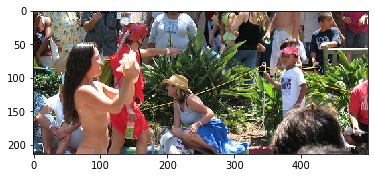

prediction: group of people are standing in front of crowd
Ground Truth: boy in red hat admires barely dressed woman
Ground Truth: man in red costume and woman in bikini are passing crowd of people
Ground Truth: smiling topless woman holding shell with many people surrounding her
Ground Truth: topless woman is holding conch shell while crowd looks at her
Ground Truth: many people watching performance


In [20]:
#OBSERVATION OF PERFORMANCE ON RANDOM IMAGES FROM DEV DATASET
key = list(dev_dataset.keys())[np.random.randint(0, 1000)]
print("model6")
print(key)
feature_vec = encoded_dev_images[key].reshape((1, 1536))
image_path = "../../../Downloads/Flickr8k/Flicker8k_dataset/"+key+".jpg"
image_ = plt.imread(image_path)
plt.imshow(image_)
plt.show()
print("prediction: {}".format(predict6(feature_vec)))
for caption in dev_dataset[key]:
    caption = ' '.join(caption.split()[1:-1])
    print("Ground Truth: {}".format(caption))

In [16]:
#PERFORMANCE ON TRAIN DATASET, DEV DATASET
batch_size = 3
steps = len(train_dataset)//batch_size
train_generator = data_generator(train_dataset, encoded_train_images, word_to_index, max_caption_length, batch_size)
train_performance = model6.evaluate(train_generator, steps=steps, verbose=0)

batch_size = 4
steps = len(dev_dataset)//batch_size
dev_generator = data_generator(dev_dataset, encoded_dev_images, word_to_index, max_caption_length, batch_size)
dev_performance = model6.evaluate(dev_generator, steps=steps, verbose=0)

print("LOSS ON TRAIN DATASET: {}".format(train_performance))
print("LOSS ON DEV DATASET: {}".format(dev_performance))

LOSS ON TRAIN DATASET: [2.261608600616455, 0.4614713490009308]
LOSS ON DEV DATASET: [4.086386203765869, 0.3352355360984802]
